# Import Libraries

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib.ticker as tkr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [26]:
births = pd.read_csv('Births2015.csv')

In [27]:
births

Unnamed: 0        date  births wday  year  month  day_of_year  \
0             1  2015-01-01    8068  Thu  2015      1            1   
1             2  2015-01-02   10850  Fri  2015      1            2   
2             3  2015-01-03    8328  Sat  2015      1            3   
3             4  2015-01-04    7065  Sun  2015      1            4   
4             5  2015-01-05   11892  Mon  2015      1            5   
..          ...         ...     ...  ...   ...    ...          ...   
360         361  2015-12-27    7518  Sun  2015     12          361   
361         362  2015-12-28   13100  Mon  2015     12          362   
362         363  2015-12-29   13458  Tue  2015     12          363   
363         364  2015-12-30   13100  Wed  2015     12          364   
364         365  2015-12-31   11608  Thu  2015     12          365   

     day_of_month  day_of_week  
0               1            5  
1               2            6  
2               3            7  
3               4            1  
4               5            2  
..            ...          ...  
360            27            1  
361            28            2  
362            29            3  
363            30            4  
364            31            5  

[365 rows x 9 columns]

1: EDA and plot the monthly distribution for each month.

2: Analyse the timeseries and make comment on its parts. Check if it is ready for forecasting and make any alterations required. 

3: Create a 1st Naive-baseline model which says: "What happened yestreday will happen tomorrow."

4: Fit an ARIMA model after selecting proper values from the according plots.

5: Fit a simple AR model and try to incorporate seasonal effect.

6: Try to fit the best ARIMA model and examine your results.

7: Fit a Prophet model.

In [28]:
births.drop('Unnamed: 0', axis=1, inplace=True)

In [29]:
births

date  births wday  year  month  day_of_year  day_of_month  \
0    2015-01-01    8068  Thu  2015      1            1             1   
1    2015-01-02   10850  Fri  2015      1            2             2   
2    2015-01-03    8328  Sat  2015      1            3             3   
3    2015-01-04    7065  Sun  2015      1            4             4   
4    2015-01-05   11892  Mon  2015      1            5             5   
..          ...     ...  ...   ...    ...          ...           ...   
360  2015-12-27    7518  Sun  2015     12          361            27   
361  2015-12-28   13100  Mon  2015     12          362            28   
362  2015-12-29   13458  Tue  2015     12          363            29   
363  2015-12-30   13100  Wed  2015     12          364            30   
364  2015-12-31   11608  Thu  2015     12          365            31   

     day_of_week  
0              5  
1              6  
2              7  
3              1  
4              2  
..           ...  
360            1  
361            2  
362            3  
363            4  
364            5  

[365 rows x 8 columns]

In [30]:
births.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          365 non-null    object
 1   births        365 non-null    int64 
 2   wday          365 non-null    object
 3   year          365 non-null    int64 
 4   month         365 non-null    int64 
 5   day_of_year   365 non-null    int64 
 6   day_of_month  365 non-null    int64 
 7   day_of_week   365 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 22.9+ KB


In [31]:
births.describe()

births    year       month  day_of_year  day_of_month  \
count    365.000000   365.0  365.000000   365.000000    365.000000   
mean   10899.991781  2015.0    6.526027   183.000000     15.720548   
std     2076.683881     0.0    3.452584   105.510663      8.808321   
min     6515.000000  2015.0    1.000000     1.000000      1.000000   
25%     8431.000000  2015.0    4.000000    92.000000      8.000000   
50%    11883.000000  2015.0    7.000000   183.000000     16.000000   
75%    12339.000000  2015.0   10.000000   274.000000     23.000000   
max    13949.000000  2015.0   12.000000   365.000000     31.000000   

       day_of_week  
count   365.000000  
mean      4.002740  
std       2.000685  
min       1.000000  
25%       2.000000  
50%       4.000000  
75%       6.000000  
max       7.000000

In [32]:
#Check %of missing values
births.isnull().sum()

date            0
births          0
wday            0
year            0
month           0
day_of_year     0
day_of_month    0
day_of_week     0
dtype: int64

There are no missing values so we can proceed.

Transform our series datetime and specify datetime as index. 

Important when we are working on a timeseries analysis.

In [33]:
births.columns

Index(['date', 'births', 'wday', 'year', 'month', 'day_of_year',
       'day_of_month', 'day_of_week'],
      dtype='object')

In [34]:
births['date'] = pd.to_datetime(births['date'])
births_only = births.drop(columns = ['wday', 'year', 'month', 'day_of_year',
      'day_of_month', 'day_of_week'])


In [35]:
births_only.head()

date  births
0 2015-01-01    8068
1 2015-01-02   10850
2 2015-01-03    8328
3 2015-01-04    7065
4 2015-01-05   11892

In [36]:
births_only.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    365 non-null    datetime64[ns]
 1   births  365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [37]:
births = births.set_index('date')
births_only = births_only.set_index('date')

In [118]:
births_only

births
date              
2015-01-01    8068
2015-01-02   10850
2015-01-03    8328
2015-01-04    7065
2015-01-05   11892
...            ...
2015-12-27    7518
2015-12-28   13100
2015-12-29   13458
2015-12-30   13100
2015-12-31   11608

[365 rows x 1 columns]

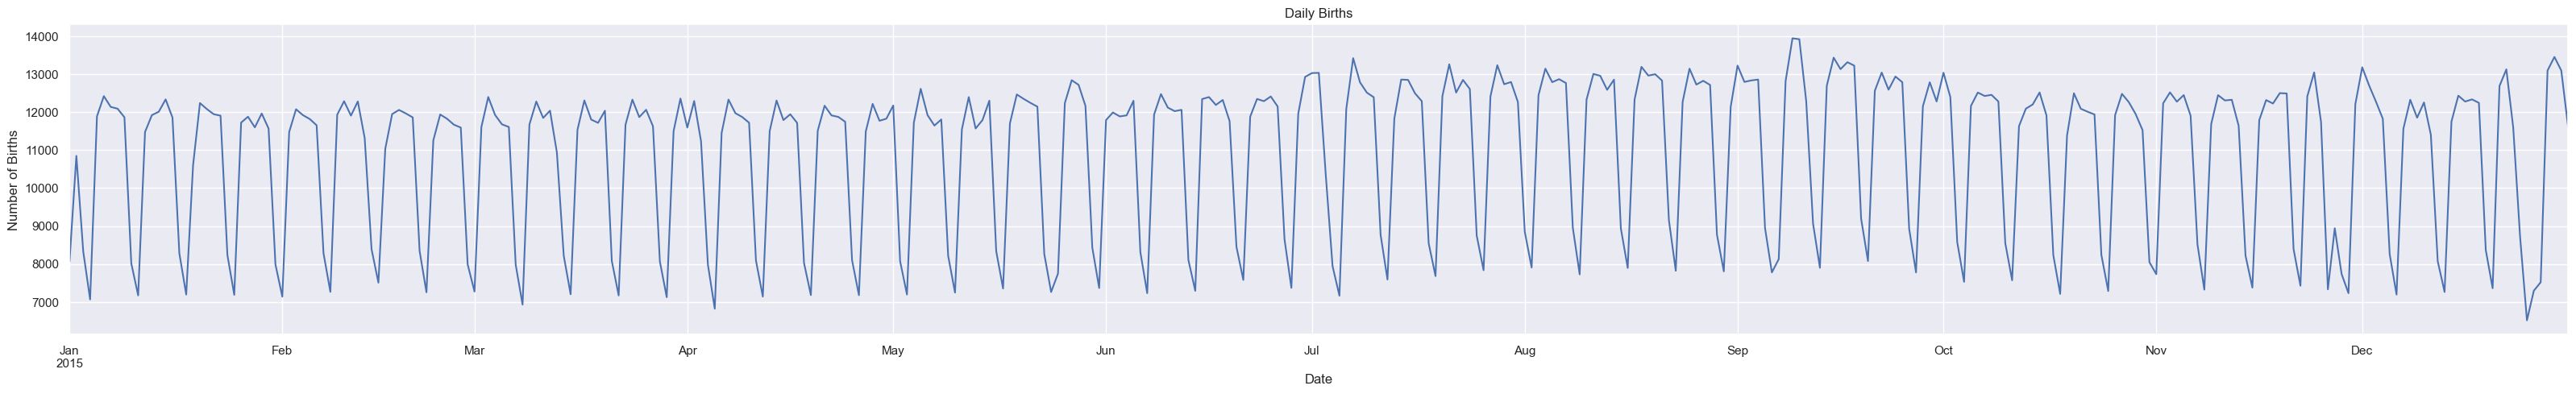

In [50]:
# Plot the data
plt.figure(figsize=(40, 5))
births_only['births'].plot()
plt.title('Daily Births')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.grid(True)
plt.show()

In [39]:
births.head()

births wday  year  month  day_of_year  day_of_month  day_of_week
date                                                                        
2015-01-01    8068  Thu  2015      1            1             1            5
2015-01-02   10850  Fri  2015      1            2             2            6
2015-01-03    8328  Sat  2015      1            3             3            7
2015-01-04    7065  Sun  2015      1            4             4            1
2015-01-05   11892  Mon  2015      1            5             5            2

In [40]:
births.tail()

births wday  year  month  day_of_year  day_of_month  day_of_week
date                                                                        
2015-12-27    7518  Sun  2015     12          361            27            1
2015-12-28   13100  Mon  2015     12          362            28            2
2015-12-29   13458  Tue  2015     12          363            29            3
2015-12-30   13100  Wed  2015     12          364            30            4
2015-12-31   11608  Thu  2015     12          365            31            5

In [41]:
births.shape

(365, 7)

# EDA and Violinplot for Moths performance

In [42]:
# Replace numerical values with Month Names


births['month']=births['month'].replace(to_replace =[1,2,3,4,5,6,7,8,9,10,11,12],
value =["January","February","March","April","May","June","July","August","September","October","November","December"])

In [43]:
births.head()

births wday  year    month  day_of_year  day_of_month  day_of_week
date                                                                          
2015-01-01    8068  Thu  2015  January            1             1            5
2015-01-02   10850  Fri  2015  January            2             2            6
2015-01-03    8328  Sat  2015  January            3             3            7
2015-01-04    7065  Sun  2015  January            4             4            1
2015-01-05   11892  Mon  2015  January            5             5            2

## Create violinplots in order to examin the montlhy births distribution

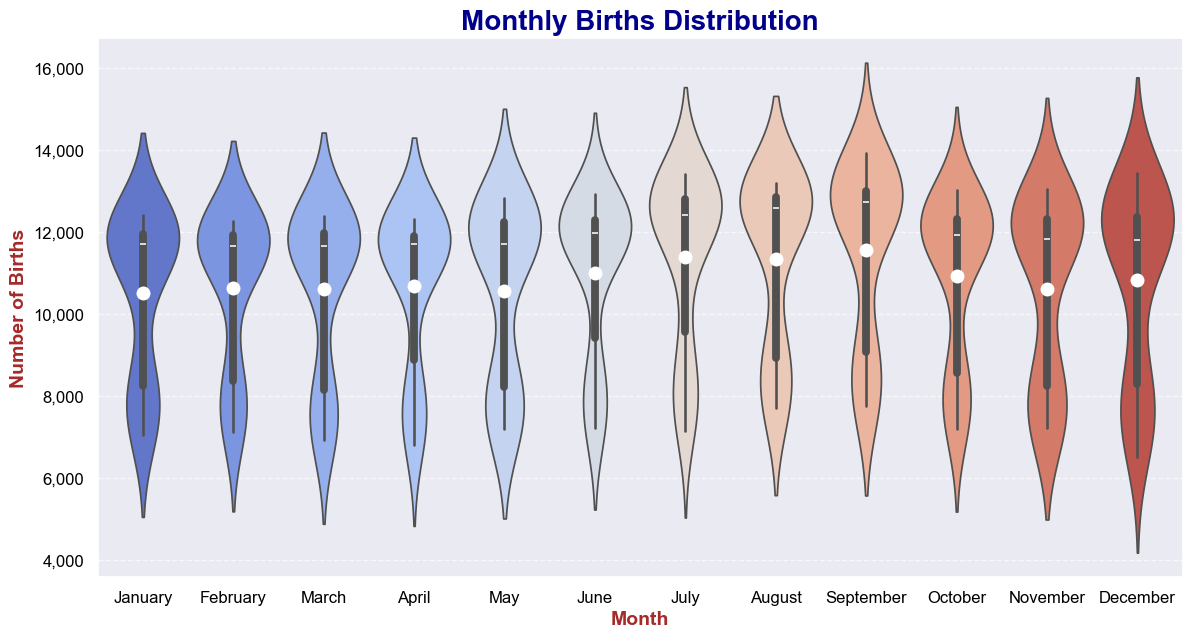

In [44]:
# Create the figure
plt.figure(figsize=(14, 7))

# Violin plot with 'hue' assigned to 'x' to avoid deprecation warning
ax = sns.violinplot(
    data=births, 
    y="births", 
    x="month",
    hue="month",  # Assign x variable to hue
    palette="coolwarm",  
    #inner="quartile",
    legend=False  # Hide duplicate legends
)

# Overlay mean values with white dots
sns.pointplot(
    data=births, 
    y="births", 
    x="month", 
    color="white", 
    markers="o", 
    linestyles="",  # No lines
    errorbar=None,  # No confidence intervals
    dodge=True,
    markersize=8  # Use markersize instead of scale
)

# Customize labels and title
ax.set_title("Monthly Births Distribution", fontweight="bold", fontsize=20, color="darkblue")
ax.set_ylabel("Number of Births", fontweight="bold", fontsize=14, color="brown")
ax.set_xlabel("Month", fontweight="bold", fontsize=14, color="brown")

# Format y-axis ticks with commas for readability
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, _: f"{int(y):,}"))

# Improve x-axis labels
plt.xticks(fontsize=12, color="black")
plt.yticks(fontsize=12, color="black")

# Add grid lines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

### How to read the graph:

- Shape (Width of the Violin) → Frequency/Density
    - Wider sections indicate more frequent birth counts for that month.
    - Narrower sections indicate fewer occurrences of those birth counts.
- White Dots → Mean Births per Month
    - Each white dot represents the mean number of births for that month.
- Thick Black Line (Vertical Bar) → Interquartile Range (IQR)
    - Represents the middle 50% of the data (from the 25th to the 75th percentile).
    - If this bar is long, the data is more spread out; if short, births are more concentrated around the median.
- Tails (Extreme Ends) → Min/Max Births
    - The upper and lower edges of each violin show the full range of births.
    - If a tail is long, it suggests more variability or occasional extreme values.

## Insights:
- Births appear fairly stable across months, with some seasonal variation.
- Summer months (June-August) show slightly higher births, as indicated by the white dots.
- December has a slightly narrower spread, suggesting more consistent birth counts.

# Series Decomposition

In time series analysis, additive and multiplicative models are two common approaches used to decompose a time series into its underlying components. These components typically include:

- Trend: The long-term movement or direction in the data.

- Seasonality: Regular, repeating patterns or cycles (e.g., monthly or yearly patterns).

- Residual (or Noise): The irregular, random fluctuations that cannot be explained by trend or seasonality.

The choice between an additive or multiplicative model depends on how these components interact with each other in the data.

- If the seasonal fluctuations grow or shrink over time, we use a multiplicative model.
- If the seasonal fluctuations are constant, we use an additive model.

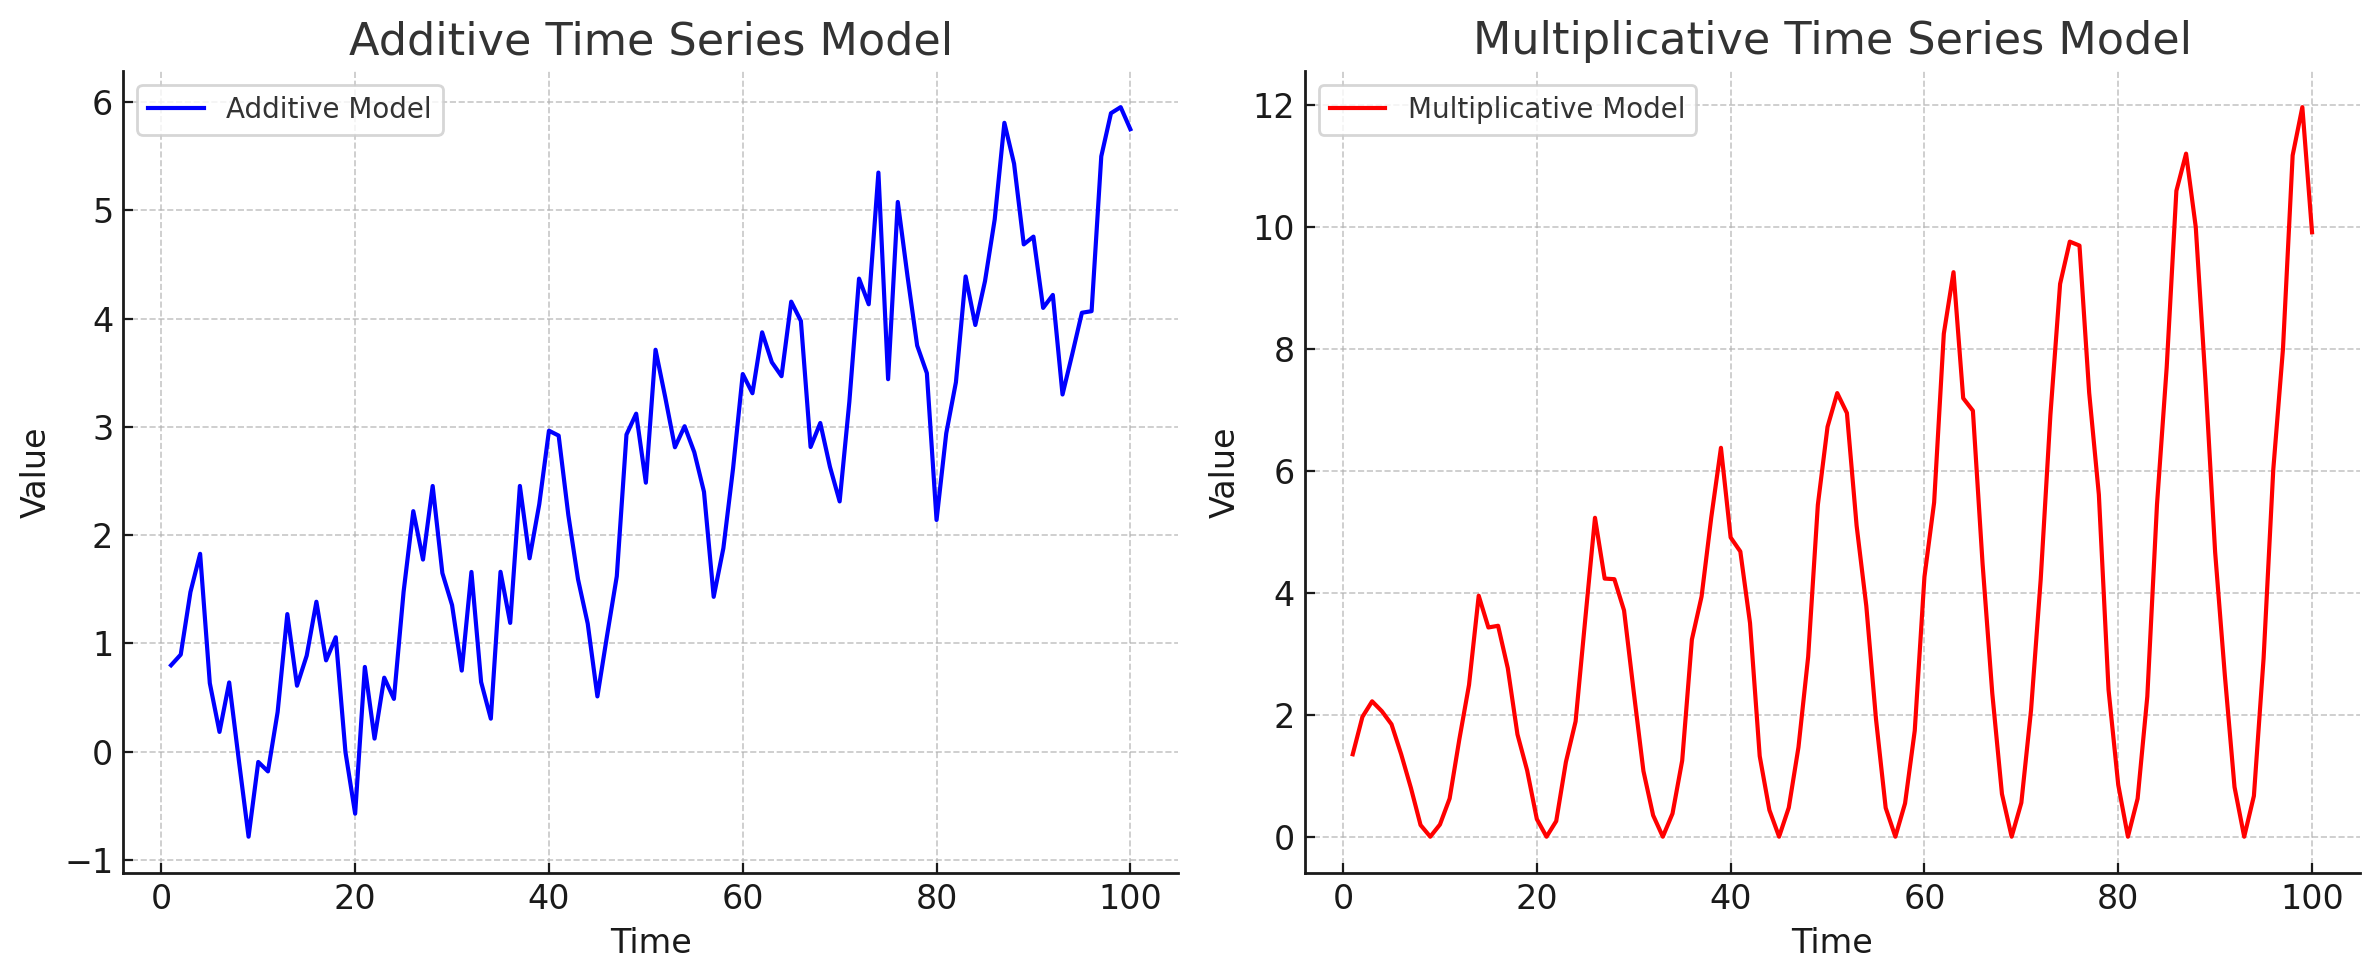

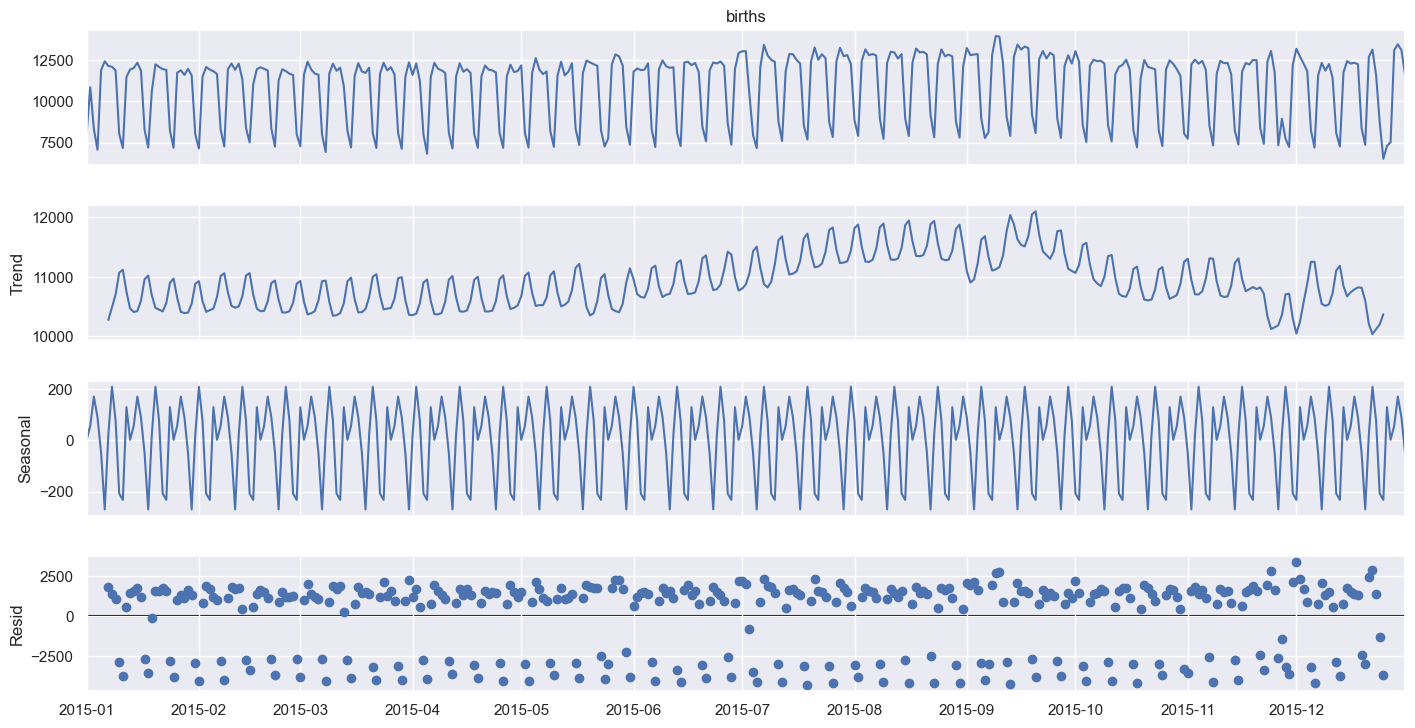

In [45]:
# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(births['births'], period=12, model='additive')

# Plot the decomposition components
fig = decomposition.plot()

# Set the figure size
fig.set_size_inches(16, 8)  # Adjust width and height as needed

plt.show()

1. Original Data (Top Plot - "births")
- There is strong seasonality with peaks and troughs repeating at regular intervals.
- The overall trend appears to be increasing at certain points and decreasing at others.

2. Trend Component (Second Plot - "Trend")
- The trend line shows an upward movement in the middle of the year, followed by a downward trend towards the end.
- This indicates that births may follow a general increasing and decreasing pattern over time.
- There is no strict stationarity since the trend is not constant.

3. Seasonal Component (Third Plot - "Seasonal")

- The pattern repeats in a consistent and periodic manner.
- Since I used period=12, this suggests that births exhibit a monthly seasonality effect.
- The seasonal fluctuations are roughly stable in amplitude, which is typical in an additive model.

4. Residual Component (Bottom Plot - "Resid")

- Residuals (random noise) should ideally be randomly scattered around zero with no clear pattern.
- Here, the spread of residuals seems wider at certain points, which might suggest some heteroscedasticity (variance changes over time).

Conclusions:
The data seem not stationary due to the clear trend and seasonality.

# Check Stationarity (Plot and Dickey-Fuller Test)

- In order a timeseires to be more easily forecasted, it should be stationary.
- In order a series to be stationary it should not be time dependent and it should hav esteady mean and std.
- Also the Dickey-Fuller Test shows all the necessary values in order to judge whether or not we have a stationary series.

## Dickey-Fuller Test:
- Null Hypothesis (H₀): The time series has a unit root → It is non-stationary (i.e., it has some trend or autocorrelation).
- Alternative Hypothesis (H₁): The time series does not have a unit root → It is stationary (i.e., the statistical properties like mean and variance remain constant over time).

If the p-value is low (< 0.05) and the test statistic is smaller than the critical values, we reject H₀ and conclude that the series is stationary.

This function, test_stationarity(), is designed to assess whether a time series is stationary by:

- Plotting rolling statistics (mean & standard deviation)
- Running the Augmented Dickey-Fuller (ADF) test and printing its results

In [55]:
# Function for Stationarity
# Plot and Dickey-Fuller Test

def test_stationarity(timeseries): #The function takes in a time series as input.
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean() # window size of 12 means it averages over the last 12 data points
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    #The Augmented Dickey-Fuller (ADF) test is performed using the adfuller() function from statsmodels.tsa.stattools.
    dftest = adfuller(timeseries, autolag='AIC') # autolag='AIC' automatically selects the best lag based on the Akaike Information Criterion (AIC).
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

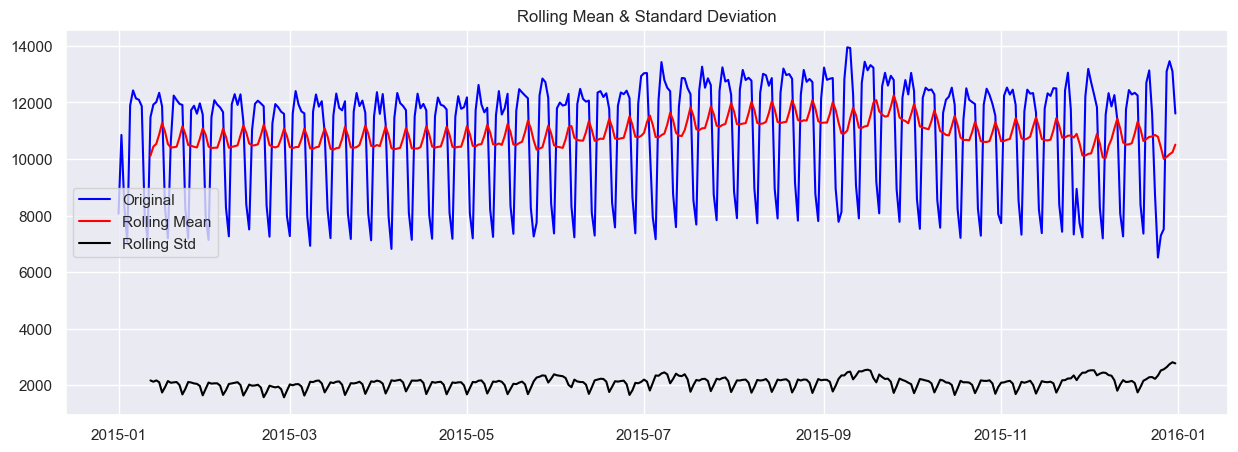

Results of Dickey-Fuller Test:
Test Statistic                  -1.601399
p-value                          0.482890
#Lags Used                      14.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


In [53]:
# Use function

test_stationarity(births['births'])

It is observed that we do not have a stationary series.

1) The mean and standard deviation are not constant, meaning the series is non-stationary. 
- The rolling mean shows a clear upward trend over time, indicating that the series is not stationary.
- The rolling standard deviation (std) appears to be increasing slightly over time, especially towards the end of the period.

2) The p-value (0.4829) is much greater than the common significance levels (0.01, 0.05, or 0.10), further confirming that we cannot reject the null hypothesis.

3) The test statistic (-1.6014) is higher than all the critical values (-3.449 at 1%, -2.869 at 5%, and -2.571 at 10%). This means we fail to reject the null hypothesis (H₀: The series has a unit root, meaning it is non-stationary).



# Transform our timeseries to stationary

1. First-order differencing: df.diff() to remove the trend.

In [60]:
births_only.head()

births
date              
2015-01-01    8068
2015-01-02   10850
2015-01-03    8328
2015-01-04    7065
2015-01-05   11892

In [61]:
# Take difference in order to create a stationary series

births_diff = births_only.diff()


In [62]:
births_diff.head()

births
date              
2015-01-01     NaN
2015-01-02  2782.0
2015-01-03 -2522.0
2015-01-04 -1263.0
2015-01-05  4827.0

In [63]:
births_diff = births_diff.dropna()

In [64]:
births_diff.head()

births
date              
2015-01-02  2782.0
2015-01-03 -2522.0
2015-01-04 -1263.0
2015-01-05  4827.0
2015-01-06   533.0

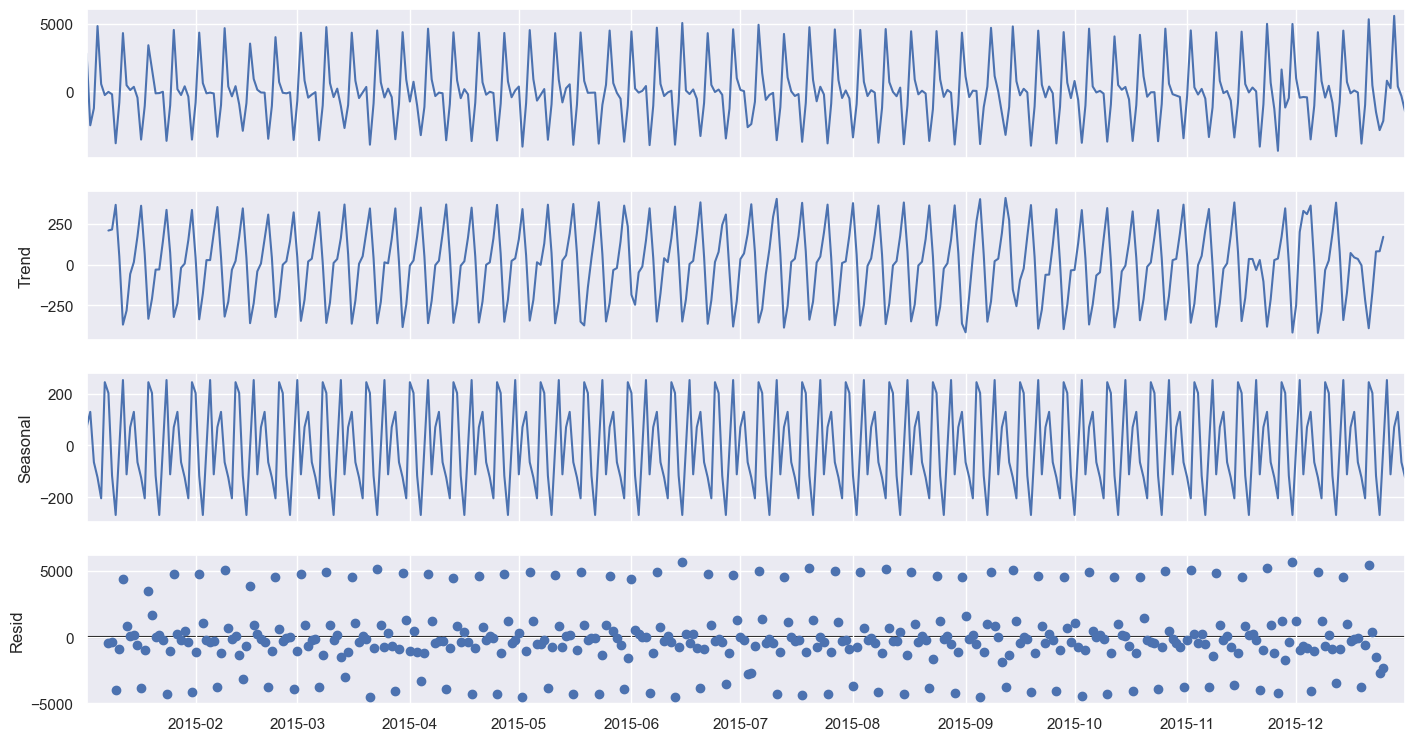

In [68]:
#Plot again the decomposition to check the diffenced series

decomposition_2 = sm.tsa.seasonal_decompose(births_diff,period = 12)

# Plot the decomposition components
fig_2 = decomposition_2.plot()

# Set the figure size
fig_2.set_size_inches(16, 8)  # Adjust width and height as needed

plt.show()

1. Observed Component (First Plot)
- The original series is now more stationary, with fluctuations centered around zero.

2. Trend Component (Second Plot)
- Unlike before, the trend component is much less pronounced and fluctuates around zero.

3. Seasonal Component (Third Plot)
- The seasonality remains strong and unchanged, which makes sense because differencing only removes trends, not seasonal patterns.

4. Residual Component (Fourth Plot)
- Ideally, residuals should look like white noise (randomly scattered points with no pattern).
- My residuals still show some variation and structure, suggesting the model might still capture some patterns.

## Check Stationarity again

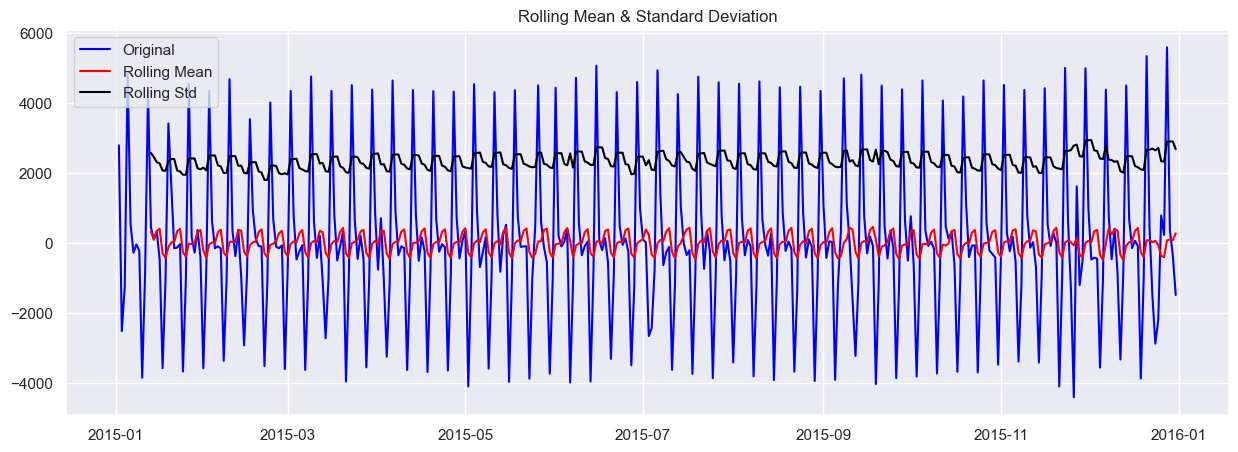

Results of Dickey-Fuller Test:
Test Statistic                -9.653695e+00
p-value                        1.412516e-16
#Lags Used                     1.300000e+01
Number of Observations Used    3.500000e+02
Critical Value (1%)           -3.449173e+00
Critical Value (5%)           -2.869833e+00
Critical Value (10%)          -2.571188e+00
dtype: float64


In [69]:
test_stationarity(births_diff)

Time series is now stationary:
- Mean seems stable over time and around zero now. Std seems more stable too.
- Test Statistic: -9.65 (way lower than all critical values)
- p-value: 1.41e-16 (<< 0.05, meaning we reject H0)

# 1. Create first Naive Model (what happened yesterday will happen tomorrow)

In [95]:
births_diff

births
date              
2015-01-02  2782.0
2015-01-03 -2522.0
2015-01-04 -1263.0
2015-01-05  4827.0
2015-01-06   533.0
...            ...
2015-12-27   224.0
2015-12-28  5582.0
2015-12-29   358.0
2015-12-30  -358.0
2015-12-31 -1492.0

[364 rows x 1 columns]

In [220]:
#Build a Naive Baseline Model (what happened yesterday will happen tomorrow)

naive_model=births_diff
naive_model=pd.concat([naive_model,naive_model.shift(1)],axis=1)
naive_model.columns=["Actual Births","Predicted Births"]


In [221]:
naive_model.head()

Actual Births  Predicted Births
date                                       
2015-01-02         2782.0               NaN
2015-01-03        -2522.0            2782.0
2015-01-04        -1263.0           -2522.0
2015-01-05         4827.0           -1263.0
2015-01-06          533.0            4827.0

In [222]:
naive_model.dropna(inplace=True)

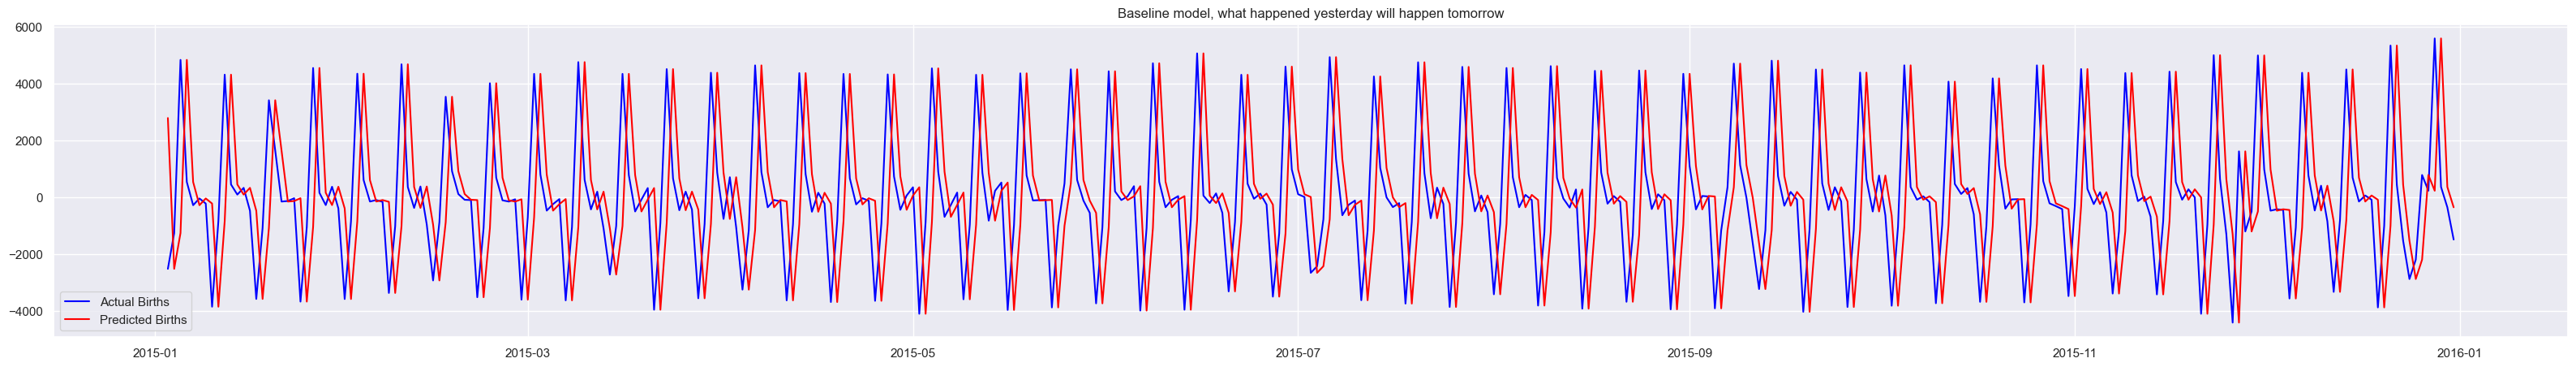

In [223]:
#Plot rolling statistics:

plt.figure(figsize=(40,5))
plt.plot(naive_model["Actual Births"], color='blue',label='Actual Births')
plt.plot(naive_model["Predicted Births"], color='red', label='Predicted Births')

plt.legend(loc='best')
plt.title('Baseline model, what happened yesterday will happen tomorrow')
plt.show(block=False)

In [224]:
# Check MSE for this first model
birth_error=mean_squared_error(naive_model["Actual Births"],naive_model["Predicted Births"])
birth_error

9421121.482093664

In [225]:
#MSE is not easy to interpretable so we will take the square root that will give us the actual birth value.
np.sqrt(birth_error)

3069.384544512737

Not good results!

# 2. ARIMA - Autoregressive (p) integrated (d) moving average (q) Model 

In order to fit an ARIMA model we should find the parameters: p, d and q.

Previously in order to make our series stationary, we took the difference with previous day, so we have d = 1

So, we have to select the remaining components p and q.

We will do it by generating and examining the ACF and PACF plots and the significance of the time lags.

## Selecting Parameters p and q through ACF and PACF plots

ACF Plot:
- The ACF plot shows the correlation between the time series and its lagged values, including indirect correlations.
- It helps in identifying the order of the moving average part (q) of the ARIMA model.

PACF Plot:
- The PACF plot shows the correlation between the time series and its lagged values, excluding the influence of intermediate lags.
- It helps in identifying the order of the autoregressive part (p) of the ARIMA model.

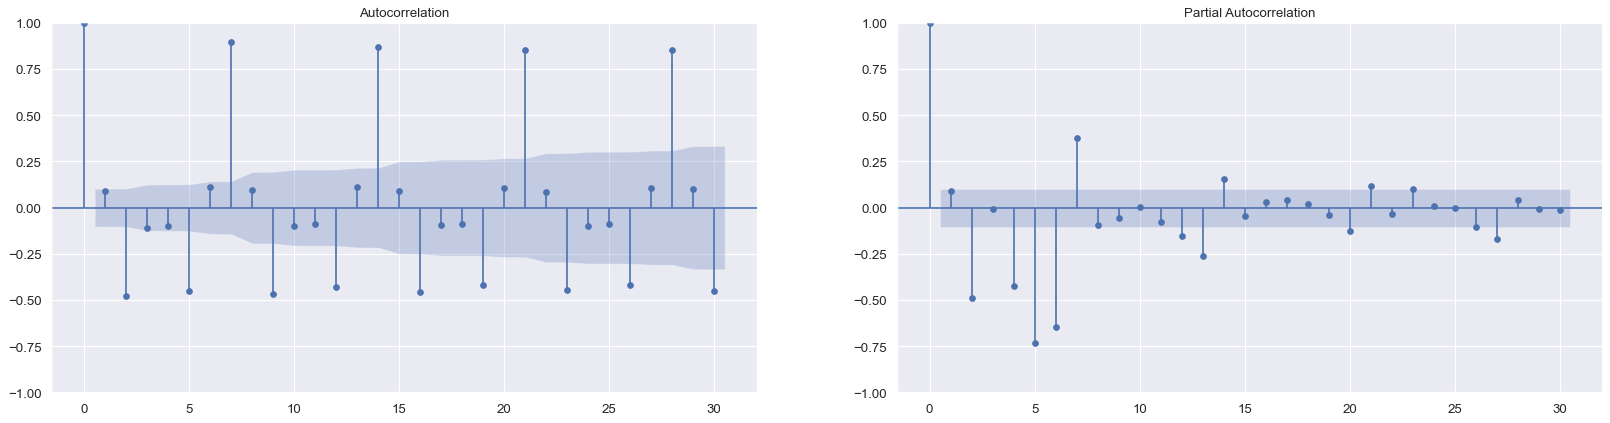

In [116]:
# Draw Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,6), dpi= 80)
plot_acf(births_diff, ax=ax1, lags=30)
plot_pacf(births_diff, ax=ax2, lags=30)

# Decorate
# lighten the borders
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

- For both the ACF and PACF graphs, I will focus only on the lags where the correlation values exceed the critical limits, as these are statistically significant.

- I will experiment with different combinations of p and q (while keeping d=1 for differencing) based on the significant lags identified in the ACF and PACF plots. 

- To evaluate the performance of these combinations, I will use Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) as error metrics. 



# Split Dataset into training and test

In [120]:
births_diff.shape

(364, 1)

In [121]:
train_births = births_diff[0:330]
test_births = births_diff[330:]


In [122]:
train_births.shape

(330, 1)

In [123]:
test_births.shape

(34, 1)

<function matplotlib.pyplot.show(close=None, block=None)>

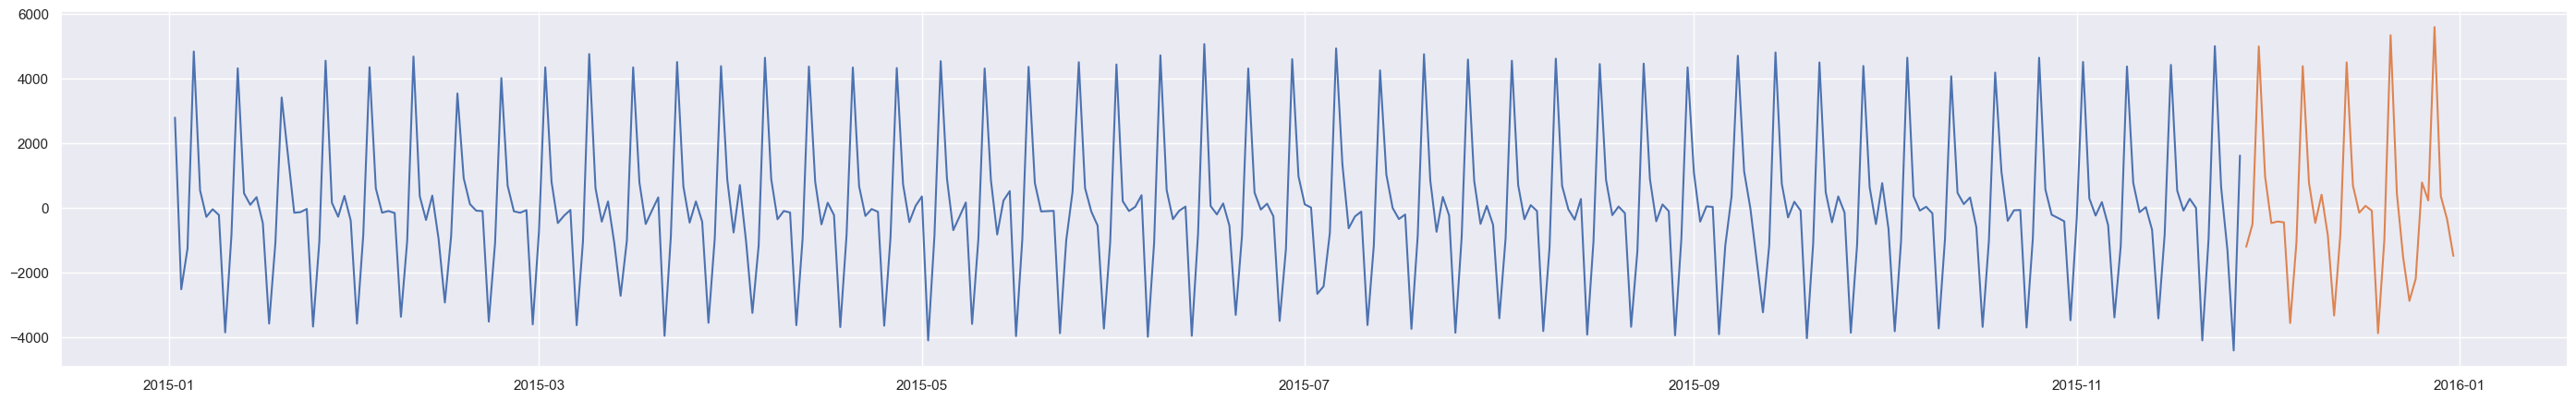

In [124]:
# Creat timeseries plot


plt.figure(figsize=(35,5))
plt.plot(train_births)
plt.plot(test_births)
plt.show

# 1st Arima Model with values from plots

let's try with p = 3, d = 1 amd q = 3

In [229]:
# Building 1st ARIMA Model

arima_1 = pm.arima.ARIMA(order=(3,1,3))
arima_1.fit(train_births)

ARIMA(order=(3, 1, 3))

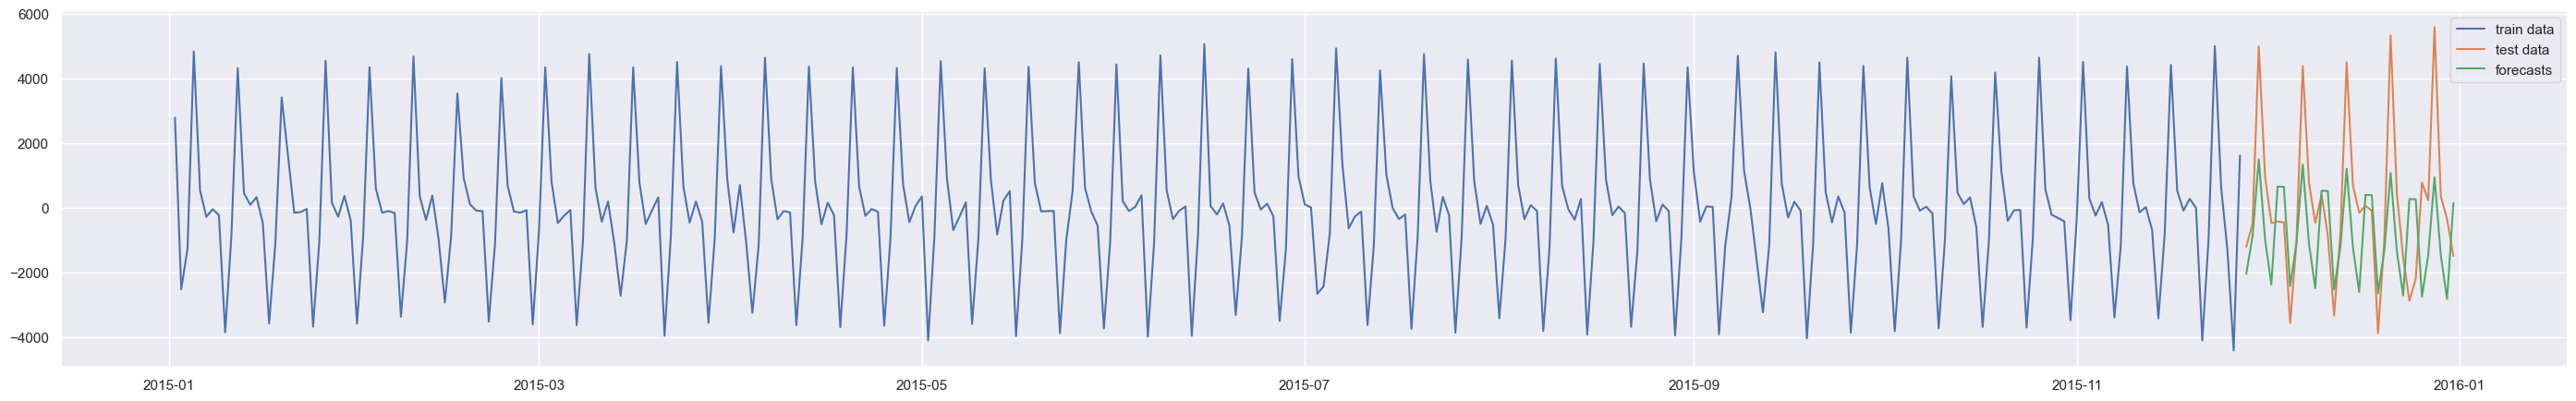

In [230]:
# Inspect Predictions

y_pred_1 = pd.DataFrame(
    arima_1.predict(n_periods=len(test_births)),  # Ensure correct length
    index=test_births.index,  # Align index with test set
    columns=['pred']
)
plt.figure(figsize=(35,5))
plt.plot(train_births, label='train data')
plt.plot(test_births, label='test data')
plt.plot(y_pred_1, label='forecasts')
plt.legend()
plt.show()

In [231]:
print(f'mean absolute error: {round(mean_absolute_error(test_births, y_pred_1), 2)} \n')

mean absolute error: 1770.62 



# 2nd Arima Model

let's try with p = 5, d=1, q =5

In [137]:
# Building 2nd ARIMA Model

arima_2 = pm.arima.ARIMA(order=(5,1,5))
arima_2.fit(train_births)

ARIMA(order=(5, 1, 5))

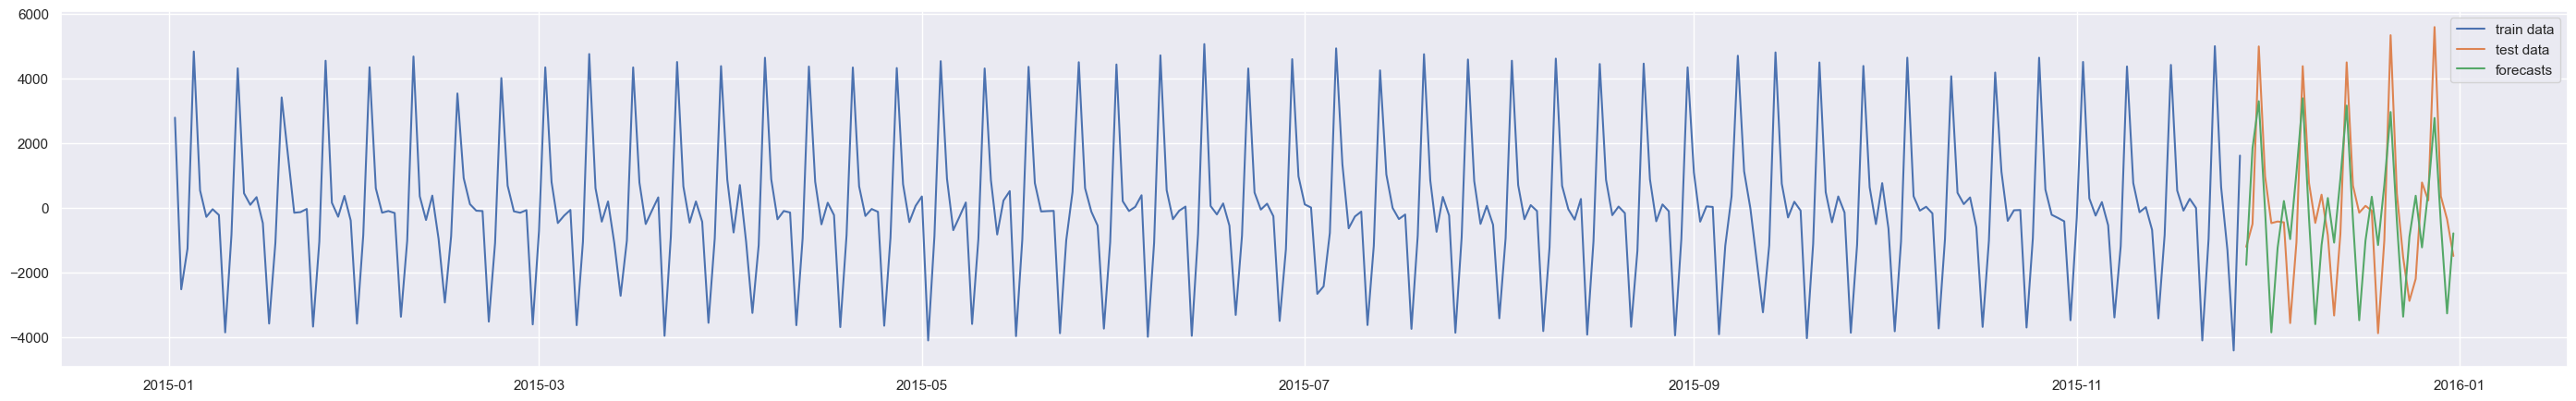

In [154]:
# Inspect Predictions


y_pred_2 = pd.DataFrame(
    arima_2.predict(n_periods=len(test_births)),  # Ensure correct length
    index=test_births.index,  # Align index with test set
    columns=['pred']
)
plt.figure(figsize=(35,5))
plt.plot(train_births, label='train data')
plt.plot(test_births, label='test data')
plt.plot(y_pred_2, label='forecasts')
plt.legend()
plt.show()

In [157]:
print(f'mean absolute error: {round(mean_absolute_error(test_births, y_pred_2), 2)} \n')

mean absolute error: 1703.62 



# 3rd Arima Model

In [205]:
arima_3 = pm.arima.ARIMA(order=(13,1,19))
arima_3.fit(train_births)

ARIMA(order=(13, 1, 19))

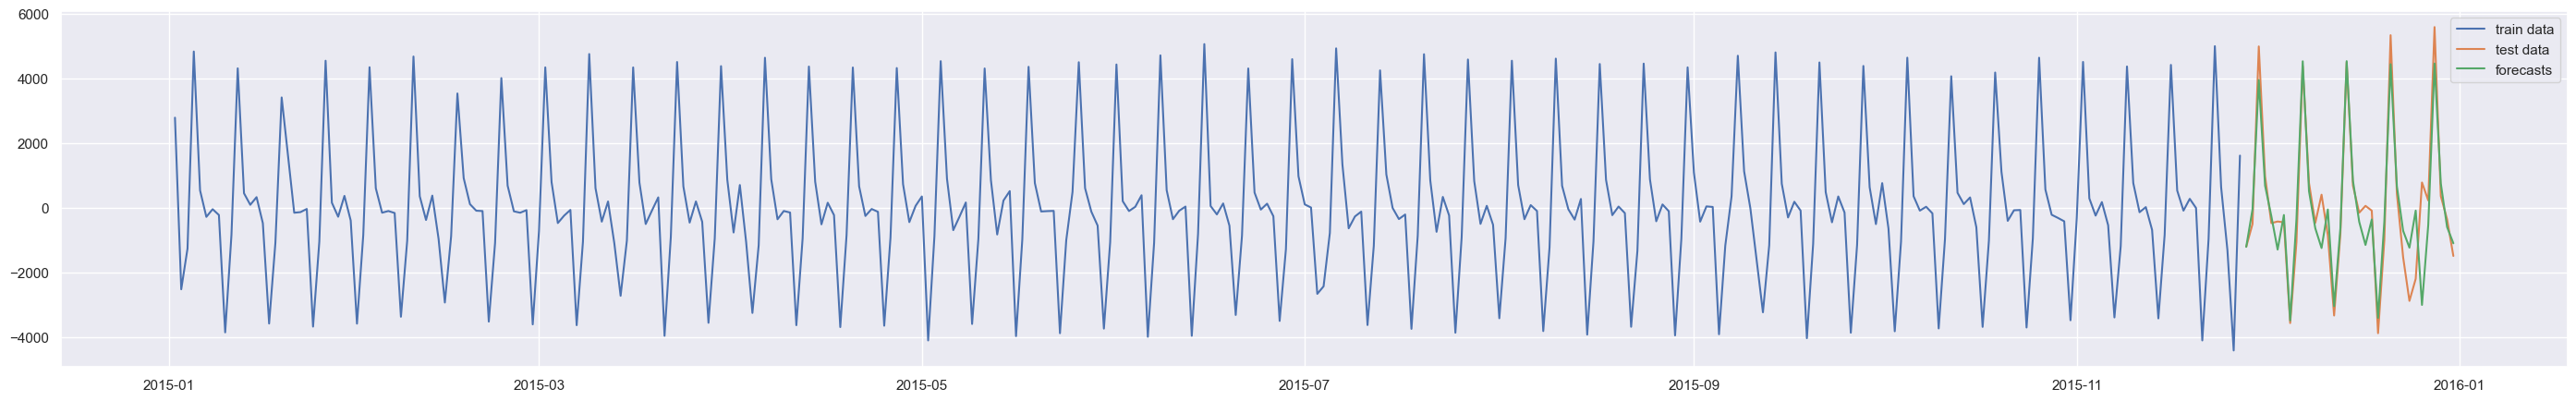

In [206]:
# Inspect Predictions


y_pred_3 = pd.DataFrame(
    arima_3.predict(n_periods=len(test_births)),  # Ensure correct length
    index=test_births.index,  # Align index with test set
    columns=['pred']
)
plt.figure(figsize=(35,5))
plt.plot(train_births, label='train data')
plt.plot(test_births, label='test data')
plt.plot(y_pred_3, label='forecasts')
plt.legend()
plt.show()

In [207]:
print(f'mean absolute error: {round(mean_absolute_percentage_error(test_births, y_pred_3), 2)} \n')
print(f'mean absolute error: {round(mean_absolute_error(test_births, y_pred_3), 2)} \n')

mean absolute error: 1.51 

mean absolute error: 668.74 



# 4th Model - Using SARIMA through Autoarima

In [216]:
# Fit stepwise auto-ARIMA with seasonal order
model = pm.auto_arima(train_births, start_p=1, start_q=1, max_p=30, max_q=30, # start and end p and q
                      test = 'adf', # use adftest to find optimal 'd'
                      seasonal=True, # We have Seasonality
                      d=None, D=None,  # let model determine 'd' we have used 1, let's see if it is the same
                      trace=True, m=7,   # trace to keep record of scores, m ->frequency of series (weekly)
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=6038.525, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6036.525, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=5790.795, Time=0.24 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=5656.756, Time=0.59 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=5286.292, Time=1.64 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=5281.572, Time=1.46 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=5655.479, Time=0.54 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(

- The first components are p=1 d=0 q=0 which are not close to the one that we I selected(13,1,19). 
- The second parantheseis are the Seasonal components 
- The last element 7, indicates the seasonal cycle (weekly data=7)

In [217]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  330
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 7)   Log Likelihood               -2634.786
Date:                                Sun, 09 Mar 2025   AIC                           5281.572
Time:                                        14:41:05   BIC                           5304.367
Sample:                                    01-02-2015   HQIC                          5290.665
                                         - 11-27-2015                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.2776      7.216     -0.593      0.553     -18.421       9.866
ar.L1         -0.2066      0.021     -9.814      0.000      -0.248      -0.165
ar.S.L7        0.9791      0.005    179.657      0.000       0.968       0.990
ma.S.L7       -0.7374      0.043    -17.131      0.000      -0.822      -0.653
ma.S.L14       0.1087      0.042      2.617      0.009       0.027       0.190
sigma2      4.585e+05   1.23e+04     37.350      0.000    4.34e+05    4.83e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.36   Jarque-Bera (JB):              2536.14
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               2.17   Skew:                            -1.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

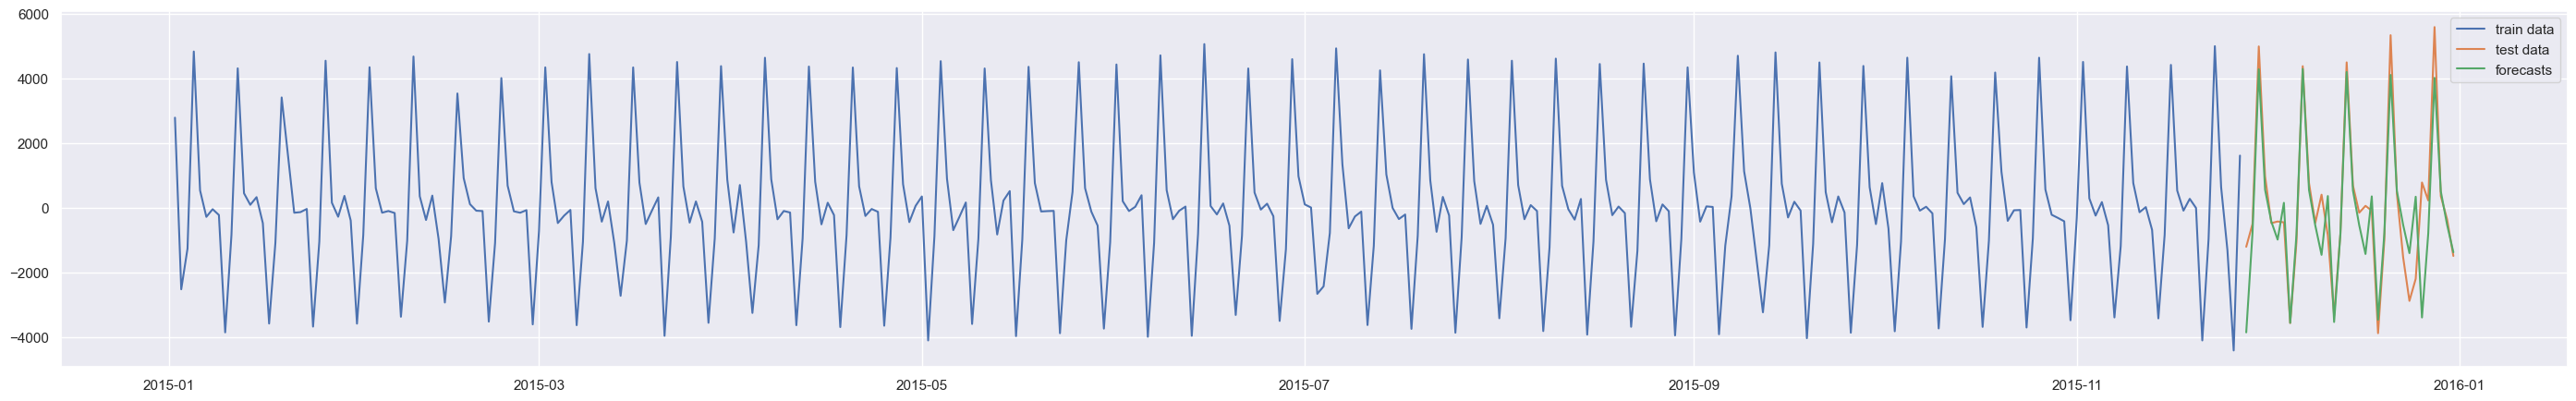

In [218]:

y_pred_4 = pd.DataFrame(
    model.predict(n_periods=len(test_births)),  # Ensure correct length
    index=test_births.index,  # Align index with test set
    columns=['pred']
)
plt.figure(figsize=(35,5))
plt.plot(train_births, label='train data')
plt.plot(test_births, label='test data')
plt.plot(y_pred_4, label='forecasts')
plt.legend()
plt.show()

In [219]:
print(f'mean absolute error: {round(mean_absolute_percentage_error(test_births, y_pred_4), 2)} \n')
print(f'mean absolute error: {round(mean_absolute_error(test_births, y_pred_4), 2)} \n')

mean absolute error: 1.78 

mean absolute error: 765.6 



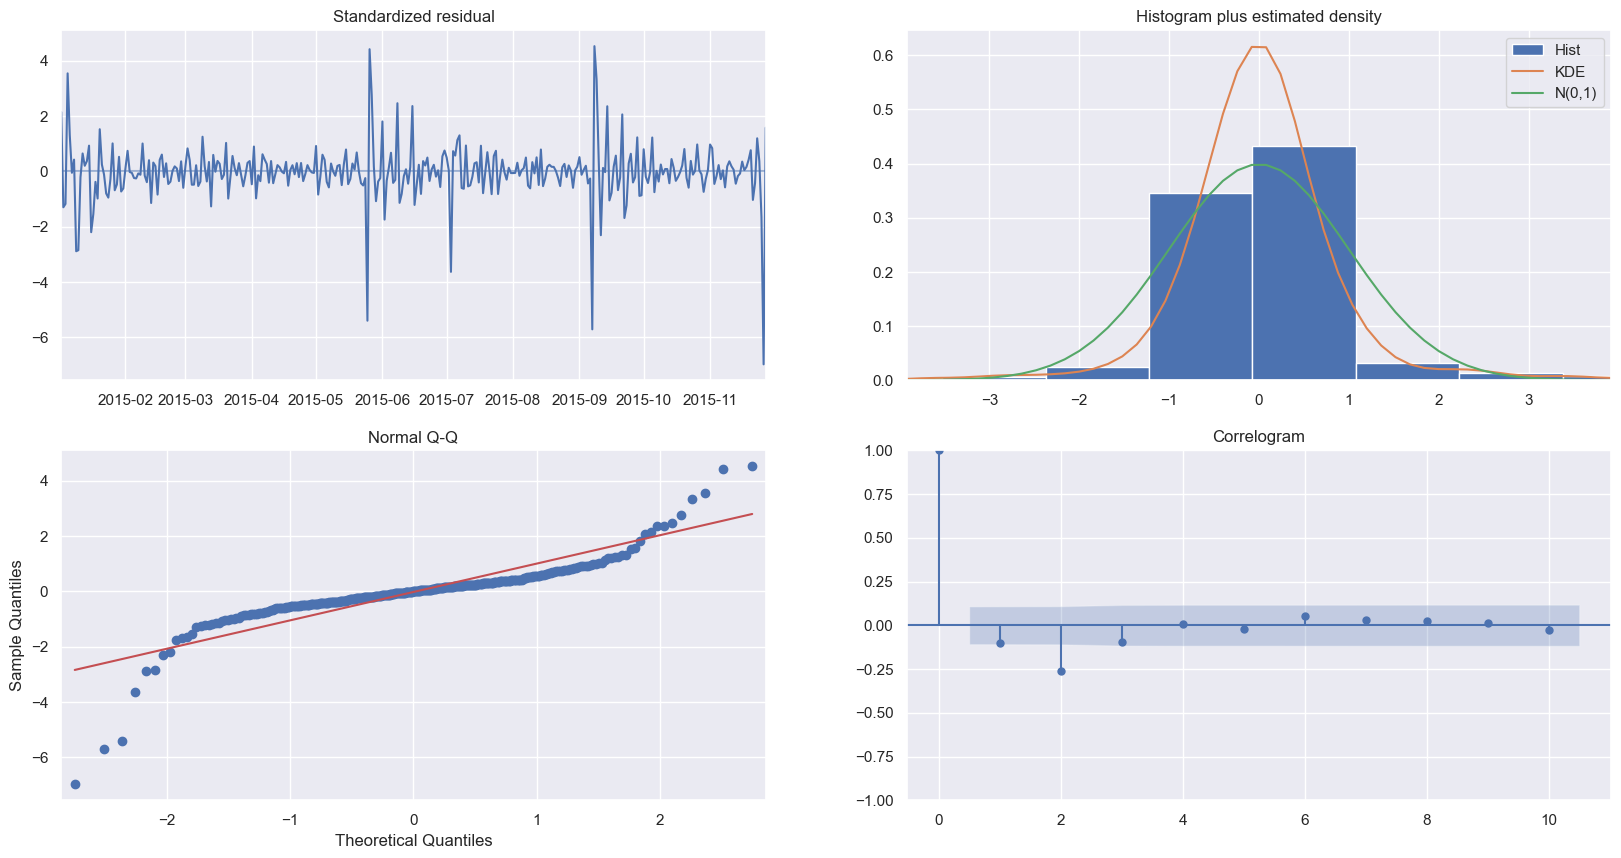

In [215]:
model.plot_diagnostics(figsize=(20,10))
plt.show()

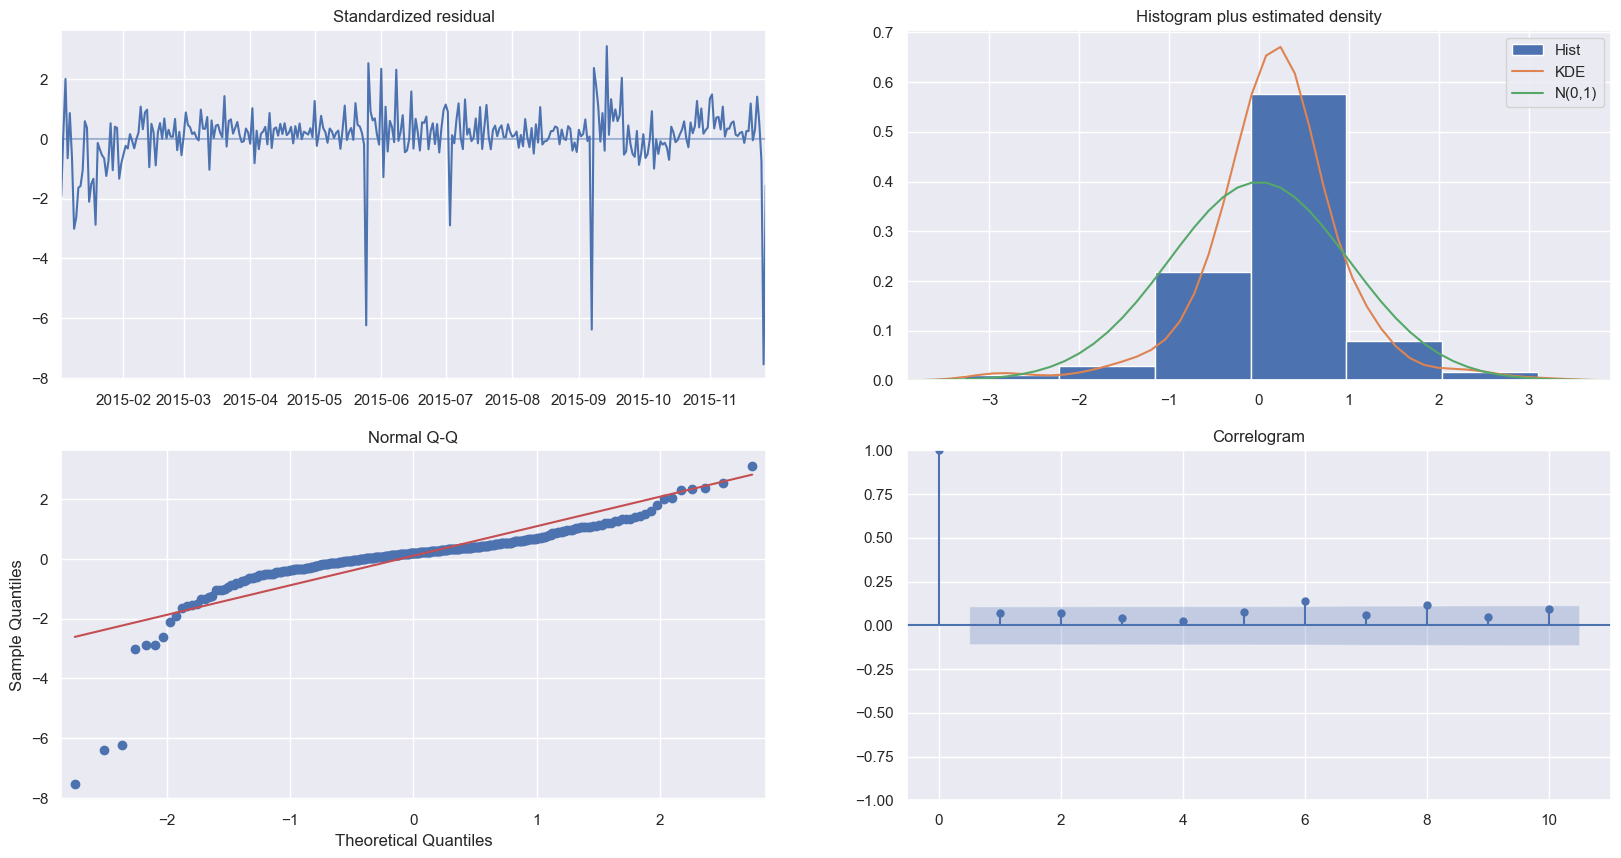

In [209]:
arima_3.plot_diagnostics(figsize=(20,10))
plt.show()

# 5th Model - Use Facebook's Prophet Library

In [236]:
# Create dataframe

prophet_births = pd.DataFrame(train_births)

In [233]:
prophet_births



births
date              
2015-01-02  2782.0
2015-01-03 -2522.0
2015-01-04 -1263.0
2015-01-05  4827.0
2015-01-06   533.0
...            ...
2015-11-23  4992.0
2015-11-24   632.0
2015-11-25 -1306.0
2015-11-26 -4413.0
2015-11-27  1610.0

[330 rows x 1 columns]

In [237]:
prophet_births.reset_index(level = 0, inplace=True)
prophet_births.columns = ['ds', 'y']
prophet_births

ds       y
0   2015-01-02  2782.0
1   2015-01-03 -2522.0
2   2015-01-04 -1263.0
3   2015-01-05  4827.0
4   2015-01-06   533.0
..         ...     ...
325 2015-11-23  4992.0
326 2015-11-24   632.0
327 2015-11-25 -1306.0
328 2015-11-26 -4413.0
329 2015-11-27  1610.0

[330 rows x 2 columns]

In [239]:
from prophet import Prophet

m = Prophet()

m.fit(prophet_births)

16:12:20 - cmdstanpy - INFO - Chain [1] start processing
16:12:21 - cmdstanpy - INFO - Chain [1] done processing


In [258]:
# Create a future dataframe for the next 34 days that is my test dataset)
future = m.make_future_dataframe(periods=34)
#future.tail()

# Predict
forecast = m.predict(future)


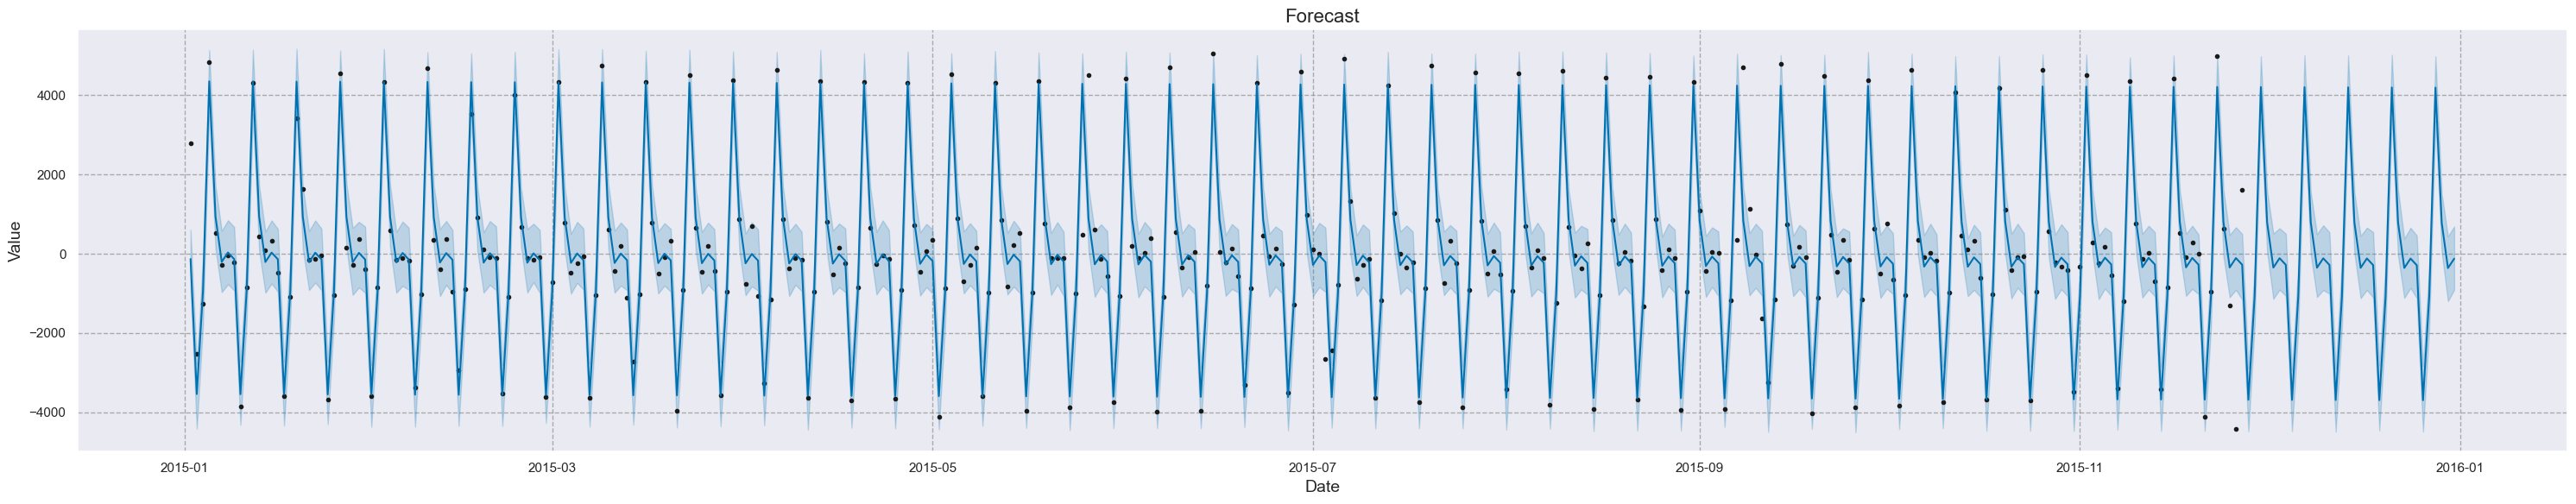

In [259]:
# Assuming 'm' is your fitted Prophet model and 'forecast' is the forecast dataframe
fig = plt.figure(figsize=(30, 6))  # Set the figure size (width, height in inches)
m.plot(forecast, ax=plt.gca())  # Plot the forecast on the current axis

# Customize the plot
plt.title('Forecast', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

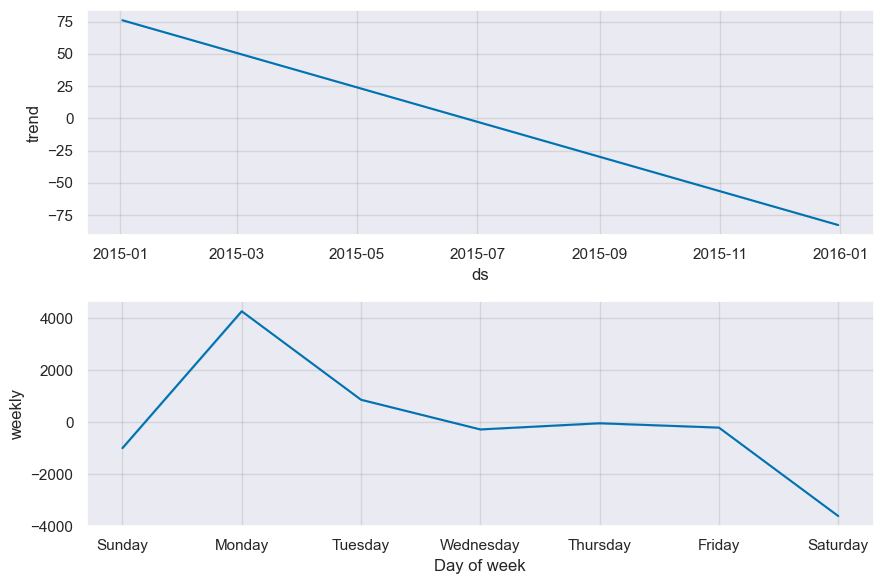

In [260]:
# Plot model components (trend, seasonality, etc.)
fig2 = m.plot_components(forecast)

In [261]:
prophet_births_test = pd.DataFrame(test_births).reset_index(drop=True)

In [263]:
prophet_births_test.columns = ['y']

In [272]:
prophet_births_test.tail()

y
29   224.0
30  5582.0
31   358.0
32  -358.0
33 -1492.0

In [266]:
prophet_births_test.shape

(34, 1)

In [267]:
forecast.shape

(364, 16)

In [273]:
forecast[['ds','yhat']].tail()

ds         yhat
359 2015-12-27 -1078.820835
360 2015-12-28  4191.460866
361 2015-12-29   783.121837
362 2015-12-30  -360.515126
363 2015-12-31  -123.657990

In [275]:
print(f'mean absolute error: {round(mean_absolute_percentage_error(prophet_births_test, forecast[['yhat']].tail(n=34)), 2)} \n')
print(f'mean absolute error: {round(mean_absolute_error(prophet_births_test, forecast[['yhat']].tail(n=34)), 2)} \n')

mean absolute error: 0.94 

mean absolute error: 714.0 



# Conclusion

Since the births range from 6,000 to 13,000, the MAPE (Mean Absolute Percentage Error) is more meaningful than MAE in evaluating my models.

## Best Model
- Model 5 - Prophet  (MAPE: 0.94%) is the best choice because it has the lowest percentage error relative to the actual birth values.
- Even though Model 3 - ARIMA ( p =13, d=1, q=19) has a lower MAE (668 vs. 714), MAPE is more critical in this case because it normalizes the error based on the actual values.